## Live updates for image of zebrafish neural activity

In [1]:
import zmq
import sys
import math
import time
import subprocess
import numpy as np
import matplotlib.pylab as plt
import pyarrow.plasma as plasma

from improv.store import Limbo, ObjectNotFoundError
from IPython.display import clear_output

Before running the next cell, the server needs to be started as well. In another terminal window besides for the one needed for this Jupyter Notebook, run `python acq_zmq.py`.

After seeing the message "the store has started" in the terminal, run the next cell!

OSError: Broken pipe

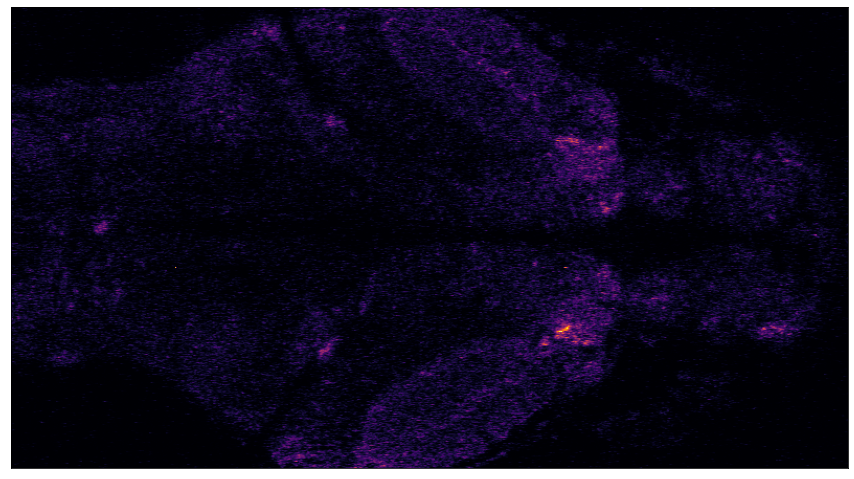

In [5]:
# connecting to the store and setting up the socket for ZMQ
lmb = Limbo(store_loc="/tmp/store")
context = zmq.Context()
socket = context.socket(zmq.SUB)
socket.connect("tcp://127.0.0.1:5555")
socket.setsockopt_string(zmq.SUBSCRIBE, '')

# configuration settings for plotting
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1) 
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
clear_output() #wait=True

# prepping to start receiving messages
timing_loop = []
n=1
print("Waiting to receive message from zmq ...")

# loop to run live image updates
while True:
    t1 = time.time()
    clear_output(wait=True)
    message = socket.recv()
    object_id = plasma.ObjectID(message)
    try:
        data = lmb.getID(object_id)
    except ObjectNotFoundError:
        pass
    
    ax.cla()
    ax.imshow(data, cmap='inferno')
    display(fig)    

    loop_time = time.time() - t1
    timing_loop.append(loop_time)
    n=n+1

## Downloading image and creating plots for timing

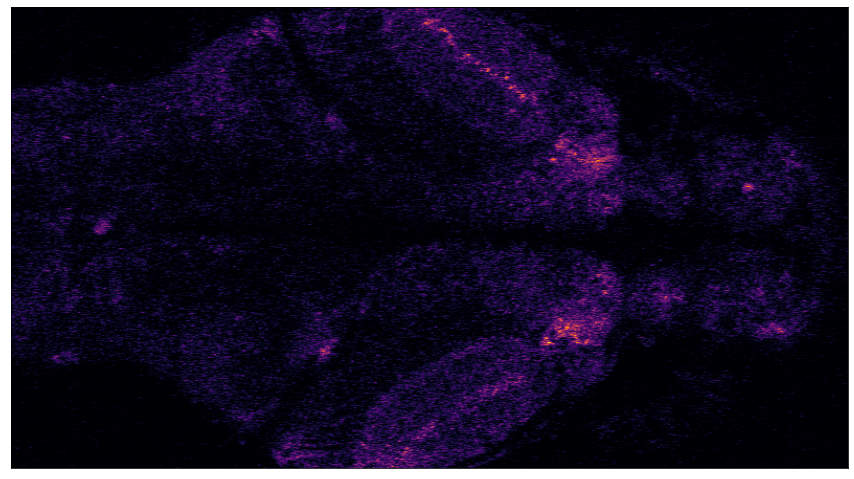

In [92]:
# saving the last image to a png file (to be used on poster)

fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(1,1,1) 
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.imshow(data, cmap='inferno')
fig.savefig('zebrafish_brain_image2.png', dpi=300)

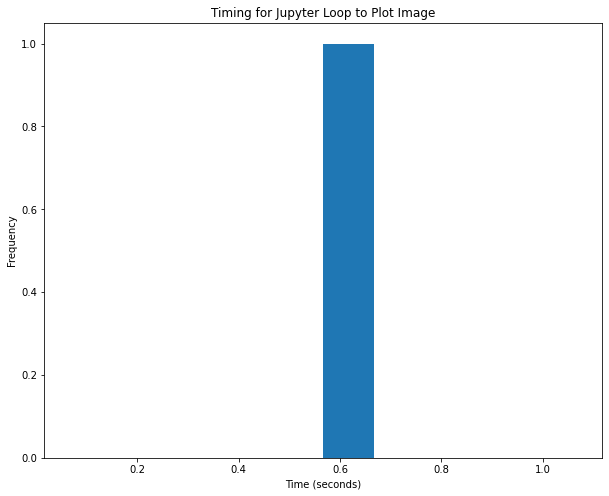

In [98]:
# histogram for loop timing

timing_loop2 = timing_loop.pop(3330) # removing outlier due to computer sleeping

fig1, ax1 = plt.subplots()

ax1.hist(timing_loop2)
plt.title('Timing for Jupyter Loop to Plot Image')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
fig1.set_size_inches(10, 8)


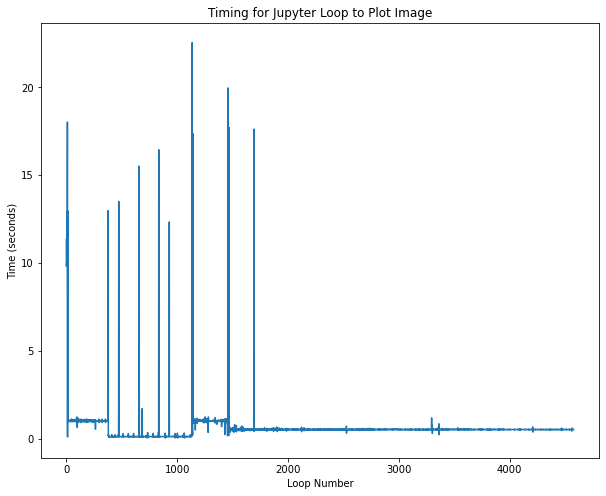

In [85]:
# loop timing over each iteration

timing_loop.pop(3330) # removing outlier due to computer sleeping
a = np.arange(len(timing_loop))

fig2, ax2 = plt.subplots()

plt.title('Timing for Jupyter Loop to Plot Image')
plt.xlabel('Loop Number')
plt.ylabel('Time (seconds)')
fig2.set_size_inches(10, 8)

ax2.plot(a, timing_loop)

In [44]:
# example for timing the different parts of the loop

lmb = Limbo(store_loc="/tmp/store")
context = zmq.Context()
socket = context.socket(zmq.SUB)
socket.connect("tcp://127.0.0.1:5555")
socket.setsockopt_string(zmq.SUBSCRIBE, '')

timestore=[]
timeconvertid=[]
timegetzmq=[]
timeplot=[]

fig, ax = plt.subplots()

n=1
print("Waiting to receive message from zmq ...")

# trying to update in loop as data comes in
while True:
    t11 = time.time()
    message = socket.recv()
    t12 = time.time() - t11
    
    t21 = time.time()
    object_id = plasma.ObjectID(message)
    t22 = time.time() - t21
    
    t31 = time.time()
    data = lmb.getID(object_id)
    t32 = time.time() - t31
    
    t41 = time.time()
    plt.imshow(data, cmap='inferno')
    plt.xlabel(message)
    plt.show()
    t42 = time.time() - t41
    
    timestore.append(t12)
    timeconvertid.append(t22)
    timegetzmq.append(t32)
    timeplot.append(t42)
    
    n=n+1
    clear_output(wait=True)

KeyboardInterrupt: 

<Figure size 1080x720 with 0 Axes>

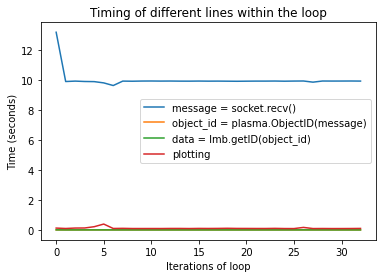

<Figure size 144x144 with 0 Axes>

In [74]:
# plotting the timing for various code lines of the main loop

w = np.arange(len(timestore))
x = np.arange(len(timeconvertid))
y = np.arange(len(timegetzmq))
z = np.arange(len(timeplot))

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

fig = plt.figure()

plt.plot(w, timestore, label="message = socket.recv()")
plt.plot(x, timeconvertid, label="object_id = plasma.ObjectID(message)")
plt.plot(y, timegetzmq, label="data = lmb.getID(object_id)")
plt.plot(z, timeplot, label = "plotting")
plt.xlabel('Iterations of loop')
plt.ylabel('Time (seconds)')
plt.title('Timing of different lines within the loop')
plt.legend() #loc='center left', bbox_to_anchor=(1, 0.5)
plt.figure(figsize=(2, 2))
fig.savefig('timing_fxns_test.jpg', dpi=200)
# plt.show()
# plt.close()